In [1]:
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import src.data.preprocessor2 as pre
import src.data.datasets2 as data
from src.model.network import create_model, quantile_loss, create_MQDCNN, MultiQuantileLoss
from src.utils import compute_coverage_len, plot_quantiles, compute_quantile, compute_quantiles_nex

In [3]:
import os
#in order not to use GPU
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  

In [10]:
removable_cols = ["sm01", "sm05", "sm06", "sm10", "sm16", "sm18", "sm19"]
ignore_columns = ["time", "os1", "os2", "os3"]

dataset = data.get_dataset("CMAPSS4", MinMaxScaler(feature_range=(-1, 1)))
split_dataset = pre.split_dataset(dataset, calval_size=0.15, random_state=0)
proc_dataset = pre.preprocess_split(split_dataset, scaler_factory=dataset["scaler_factory"], window_size=dataset["window_size"], removable_cols=removable_cols, ignore_columns=ignore_columns)

In [11]:
np.unique(split_dataset["train"]["id"])

array([  1,   2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  39,  40,  41,  42,  43,
        44,  47,  48,  49,  50,  51,  52,  53,  54,  55,  57,  58,  59,
        60,  61,  62,  63,  66,  67,  68,  69,  70,  71,  72,  73,  75,
        76,  78,  79,  80,  81,  82,  83,  85,  86,  87,  88,  89,  91,
        92,  94,  95,  96,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 111, 113, 114, 115, 116, 118, 120, 121, 122, 123,
       124, 125, 127, 128, 129, 131, 132, 133, 134, 135, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 147, 148, 149, 150, 152, 153, 154,
       155, 156, 157, 158, 159, 161, 164, 165, 166, 167, 168, 170, 171,
       172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185,
       186, 187, 188, 189, 191, 192, 193, 194, 195, 196, 197, 198, 199,
       200, 201, 205, 206, 207, 209, 210, 211, 212, 213, 215, 21

In [12]:
np.unique(split_dataset["calval"]["id"])

array([  6,   9,  23,  38,  45,  46,  56,  64,  65,  74,  77,  84,  90,
        93,  97, 110, 112, 117, 119, 126, 130, 136, 146, 151, 160, 162,
       163, 169, 177, 190, 202, 203, 204, 208, 214, 219, 230, 249],
      dtype=int64)

In [13]:
np.unique(proc_dataset["train"]["id"])

array([  1,   2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  39,  40,  41,  42,  43,
        44,  47,  48,  49,  50,  51,  52,  53,  54,  55,  57,  58,  59,
        60,  61,  62,  63,  66,  67,  68,  69,  70,  71,  72,  73,  75,
        76,  78,  79,  80,  81,  82,  83,  85,  86,  87,  88,  89,  91,
        92,  94,  95,  96,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 111, 113, 114, 115, 116, 118, 120, 121, 122, 123,
       124, 125, 127, 128, 129, 131, 132, 133, 134, 135, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 147, 148, 149, 150, 152, 153, 154,
       155, 156, 157, 158, 159, 161, 164, 165, 166, 167, 168, 170, 171,
       172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185,
       186, 187, 188, 189, 191, 192, 193, 194, 195, 196, 197, 198, 199,
       200, 201, 205, 206, 207, 209, 210, 211, 212, 213, 215, 21

In [14]:
np.unique(proc_dataset["calval"]["id"])

array([  6,   9,  23,  38,  45,  46,  56,  64,  65,  74,  77,  84,  90,
        93,  97, 110, 112, 117, 119, 126, 130, 136, 146, 151, 160, 162,
       163, 169, 177, 190, 202, 203, 204, 208, 214, 219, 230, 249],
      dtype=int64)

In [15]:
proc_dataset["train"]["X"].shape

(48666, 15, 14, 1)

In [17]:
proc_dataset["calval"]["X"].shape

(9097, 15, 14, 1)

In [18]:
proc_dataset["train"]["X"].shape[0] + proc_dataset["calval"]["X"].shape[0]

57763

# train an ordinary mean estimator for SCP and nex-SCP

In [20]:
epochs = 100 # training epochs
optimizer = Adam(learning_rate=1e-3) # model optimizer

X_train = proc_dataset["train"]["X"]
y_train = proc_dataset["train"]["y"]
DCNN = create_model(window_size=dataset["window_size"], feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
DCNN.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])
DCNN.fit(x=X_train, y=y_train, batch_size = 512, epochs = epochs)

Epoch 1/100
96/96 [==============================] - 9s 88ms/step - loss: 7473.9106 - root_mean_squared_error: 86.4518
Epoch 2/100
96/96 [==============================] - 9s 92ms/step - loss: 5846.5044 - root_mean_squared_error: 76.4624
Epoch 3/100
96/96 [==============================] - 9s 95ms/step - loss: 4775.8892 - root_mean_squared_error: 69.1078
Epoch 4/100
96/96 [==============================] - 9s 94ms/step - loss: 3943.8169 - root_mean_squared_error: 62.7998
Epoch 5/100
96/96 [==============================] - 9s 93ms/step - loss: 3296.9919 - root_mean_squared_error: 57.4194
Epoch 6/100
96/96 [==============================] - 9s 90ms/step - loss: 2793.6538 - root_mean_squared_error: 52.8550
Epoch 7/100
96/96 [==============================] - 8s 87ms/step - loss: 2400.9766 - root_mean_squared_error: 48.9998
Epoch 8/100
96/96 [==============================] - 8s 88ms/step - loss: 2087.6799 - root_mean_squared_error: 45.6911
Epoch 9/100
96/96 [=============================

# train a quantile estimator for CQR

In [21]:
alpha = 0.4
epochs = 100
quantiles = [alpha/2, 1 - alpha/2]
loss_func = MultiQuantileLoss(quantiles=quantiles)

MQDCNN = create_MQDCNN(quantiles=quantiles, window_size=dataset["window_size"], feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
MQDCNN.compile(optimizer=optimizer, loss=loss_func, metrics=[RootMeanSquaredError()])
MQDCNN.fit(x=X_train, y=y_train, batch_size = 512, epochs = epochs)

Epoch 1/100
96/96 [==============================] - 8s 81ms/step - loss: 62.2284 - q0_loss: 15.0178 - q1_loss: 47.2106 - q0_root_mean_squared_error: 79.9888 - q1_root_mean_squared_error: 70.0433
Epoch 2/100
96/96 [==============================] - 8s 86ms/step - loss: 41.7688 - q0_loss: 13.6411 - q1_loss: 28.1277 - q0_root_mean_squared_error: 64.0579 - q1_root_mean_squared_error: 46.9751
Epoch 3/100
96/96 [==============================] - 8s 84ms/step - loss: 32.2680 - q0_loss: 13.2088 - q1_loss: 19.0592 - q0_root_mean_squared_error: 60.6115 - q1_root_mean_squared_error: 39.9652
Epoch 4/100
96/96 [==============================] - 8s 79ms/step - loss: 25.8703 - q0_loss: 12.7979 - q1_loss: 13.0724 - q0_root_mean_squared_error: 57.4530 - q1_root_mean_squared_error: 39.2998
Epoch 5/100
96/96 [==============================] - 7s 72ms/step - loss: 21.3334 - q0_loss: 12.4632 - q1_loss: 8.8702 - q0_root_mean_squared_error: 55.0711 - q1_root_mean_squared_error: 41.8753
Epoch 6/100
96/96 [==

# Checking whether calibration works fine

In [26]:
R = 50
rho = 0.97
alpha = 0.1
SCP = [] #Split conformal prediction
nex_SCP = [] #non-exchangeable Split conformal prediction
CQR = [] #conformalized quantile regression


for r in range(R):
    val_idx, cal_idx = pre.split_by_group(X=proc_dataset["calval"]["X"], groups=proc_dataset["calval"]["id"], n_splits=1, test_size=0.5, random_state=r)
    X_val, X_cal = proc_dataset["calval"]["X"][val_idx], proc_dataset["calval"]["X"][cal_idx]
    y_val, y_cal = proc_dataset["calval"]["y"][val_idx], proc_dataset["calval"]["y"][cal_idx]
    idx_val, idx_cal = proc_dataset["calval"]["index"][val_idx], proc_dataset["calval"]["index"][cal_idx]
    id_val, id_cal = proc_dataset["calval"]["id"][val_idx], proc_dataset["calval"]["id"][cal_idx]

    y_hat_cal = DCNN.predict(x=X_cal, verbose=0)
    y_hat_val = DCNN.predict(x=X_val, verbose=0)
    scores = np.abs(y_cal - y_hat_cal) 
    q = compute_quantile(scores, alpha)
    q_array = compute_quantiles_nex(rho, scores, idx_val, idx_cal, alpha)
    SCP.append(compute_coverage_len(y_val, y_hat_val-q, y_hat_val+q))
    nex_SCP.append(compute_coverage_len(y_val, y_hat_val-q_array, y_hat_val+q_array))

    y_hat_cal_CQR = MQDCNN.predict(x=X_cal, verbose=0)
    y_hat_val_CQR = MQDCNN.predict(x=X_val, verbose=0)
    scores_low = y_hat_cal_CQR[0] - y_cal
    scores_high = y_cal - y_hat_cal_CQR[1] 
    scores_CQR = np.maximum(scores_low, scores_high)
    q_CQR = compute_quantile(scores_CQR, alpha)
    CQR.append(compute_coverage_len(y_val, y_hat_val_CQR[0] - q_CQR, y_hat_val_CQR[1] + q_CQR))
    


left_coverage_nex_SCP, coverage_nex_SCP, avg_length_nex_SCP =  zip(*nex_SCP)
left_coverage_SCP, coverage_SCP, avg_length_SCP =  zip(*SCP)
left_coverage_CQR, coverage_CQR, avg_length_CQR =  zip(*CQR)

(array([3., 8., 5., 7., 5., 5., 9., 2., 3., 3.]),
 array([49.253895, 52.63726 , 56.02063 , 59.404   , 62.787365, 66.17073 ,
        69.5541  , 72.93747 , 76.32083 , 79.7042  , 83.08757 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

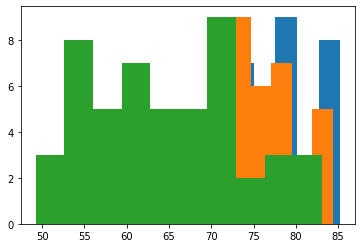

In [27]:
plt.hist(avg_length_SCP)
plt.hist(avg_length_nex_SCP)
plt.hist(avg_length_CQR)

In [31]:
print(f"SCP: {np.mean(avg_length_SCP)}, nex-SCP: {np.mean(avg_length_nex_SCP)}, CQR: {np.mean(avg_length_CQR)} ")

SCP: 74.75730895996094, nex-SCP: 73.32743072509766, CQR: 64.60408782958984 


(array([ 2.,  3.,  5.,  5.,  4.,  7.,  5., 10.,  2.,  7.]),
 array([0.82083805, 0.83485074, 0.84886342, 0.86287611, 0.8768888 ,
        0.89090148, 0.90491417, 0.91892685, 0.93293954, 0.94695223,
        0.96096491]),
 <BarContainer object of 10 artists>)

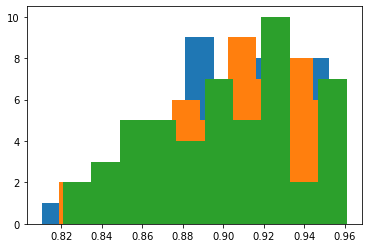

In [32]:
plt.hist(coverage_SCP)
plt.hist(coverage_nex_SCP)
plt.hist(coverage_CQR)

In [33]:
print(f"SCP: {np.mean(coverage_SCP)}, nex-SCP: {np.mean(coverage_nex_SCP)}, CQR: {np.mean(coverage_CQR)} ")

SCP: 0.9010455514906913, nex-SCP: 0.9042541726679038, CQR: 0.9000897536424719 


In [36]:
proc_dataset["test"]["index"]

array([  0,   1,   2, ..., 264, 265, 266])

# Now calibrate using calval data and test it on test  

In [154]:
alpha = 0.15
X_cal, y_cal, idx_cal = proc_dataset["calval"]["X"], proc_dataset["calval"]["y"], proc_dataset["calval"]["index"]
X_test, y_test, idx_test = proc_dataset["test"]["X"], proc_dataset["test"]["y"], proc_dataset["test"]["index"]


y_hat_cal = DCNN.predict(x=X_cal, verbose=0)
y_hat_test = DCNN.predict(x=X_test, verbose=0)
scores = np.abs(proc_dataset["test"]["y"] - y_hat_calval) 
q = compute_quantile(scores, alpha)
q_array = compute_quantiles_nex(0.9999, scores, proc_dataset2["test"]["index"], proc_dataset["test"]["index"])


print(compute_coverage_len(proc_dataset2["test"]["y"], y_hat_test - q, y_hat_test + q))
print(compute_coverage_len(proc_dataset2["test"]["y"], y_hat_test  - q_array, y_hat_test  + q_array))

y_hat_cal_CQR = MQDCNN.predict(x=proc_dataset["test"]["X"], verbose=0)
y_hat_test_CQR = MQDCNN.predict(x=proc_dataset2["test"]["X"], verbose=0)
scores_low = y_hat_calval_CQR[0] - proc_dataset["test"]["y"]
scores_high = proc_dataset["test"]["y"] - y_hat_calval_CQR[1] 
scores_CQR = np.maximum(scores_low, scores_high)
q_CQR = compute_quantile(scores_CQR, alpha)

print(compute_coverage_len(proc_dataset2["test"]["y"], y_hat_test_CQR[0] - q_CQR, y_hat_test_CQR[1] + q_CQR))

(0.9294949923162524, 0.8796301202903927, 58.217422)
(0.9333633617720312, 0.8855121615176726, 60.08143)
(0.9120078427216364, 0.8778549096497271, 41.95526)


In [155]:
print(compute_coverage_len(proc_dataset2["test"]["y"], y_hat_test_CQR[0] - q_CQR, y_hat_test_CQR[1] + q_CQR))

(0.9120078427216364, 0.8778549096497271, 41.95526)


In [ ]:
import matplotlib

plt.hist(avg_length_SCP)
plt.hist(avg_length_nex_SCP)
plt.hist(avg_length_CQR)
font = {'fontname':'Times New Roman'}
matplotlib.rc('font', **font)
plt.xlabel('average coverage')

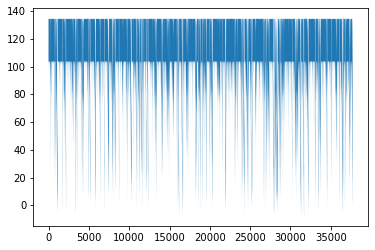

In [166]:
y_low_CQR = y_hat_test_CQR[0] - q_CQR
y_high_CQR = y_hat_test_CQR[1] + q_CQR
plt.fill_between(range(len(y_hat_test_CQR[0])), y_low_CQR.reshape(-1), y_high_CQR.reshape(-1))

In [157]:
len(y_hat_test_CQR[0])

37742

In [164]:
y_hat_test_CQR[0].reshape(-1).shape

(37742,)

In [176]:
proc_dataset2["test"]["index"][proc_dataset2["test"]["id"]==50]

array([9457, 9458, 9459, 9460, 9461, 9462, 9463, 9464, 9465, 9466, 9467,
       9468, 9469, 9470, 9471, 9472, 9473, 9474, 9475, 9476, 9477, 9478,
       9479, 9480, 9481, 9482, 9483, 9484, 9485, 9486, 9487, 9488, 9489,
       9490, 9491, 9492, 9493, 9494, 9495, 9496, 9497, 9498, 9499, 9500,
       9501, 9502, 9503, 9504, 9505, 9506, 9507, 9508, 9509, 9510, 9511,
       9512, 9513, 9514, 9515, 9516, 9517, 9518, 9519, 9520, 9521, 9522,
       9523, 9524, 9525, 9526, 9527, 9528, 9529, 9530, 9531, 9532, 9533,
       9534, 9535, 9536, 9537, 9538, 9539, 9540, 9541, 9542, 9543, 9544,
       9545, 9546, 9547, 9548, 9549, 9550, 9551, 9552, 9553, 9554, 9555,
       9556, 9557, 9558, 9559, 9560, 9561, 9562, 9563, 9564, 9565, 9566,
       9567, 9568, 9569, 9570, 9571, 9572, 9573, 9574, 9575, 9576, 9577,
       9578, 9579, 9580, 9581, 9582, 9583, 9584, 9585, 9586, 9587, 9588,
       9589, 9590, 9591, 9592, 9593, 9594, 9595, 9596, 9597, 9598, 9599,
       9600, 9601, 9602, 9603, 9604, 9605, 9606, 96

In [2]:
a = np.arange(50)

In [3]:
a.shape

(50,)

In [4]:
b = np.arange(70)

In [8]:
c = [a,b]
d = np.vstack(c)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 50 and the array at index 1 has size 70

In [9]:
d.shape

(120,)